In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 5
import numpy as np
np.random.seed(0)
from pyha import *
import scipy
from scipy import signal

import warnings
warnings.filterwarnings('ignore') # because they include system path -> fails unit tests on different computer

simulations = ['MODEL', 'HARDWARE']

# Applications

In [3]:
from pyha.cores import NCO
from pyha.cores.util import *
plt.rcParams['figure.figsize'] = 15, 5

## IQ generator

In [4]:
period = 2
fs = 1024
freq = 200
phase_inc = 2 * np.pi * freq / fs
phase_cumsum = np.arange(0, period * fs * phase_inc, phase_inc)
input_signal = np.diff(phase_cumsum) / np.pi

In [5]:
# NBVAL_IGNORE_OUTPUT
dut = NCO(cordic_iterations=14)
sims = simulate(dut, input_signal, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 2064/2064 [00:00<00:00, 2332.07it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


In [6]:
print(f"SNR: {snr(sims['MODEL'], sims['HARDWARE']):.2f} dB")

SNR: 81.36 dB


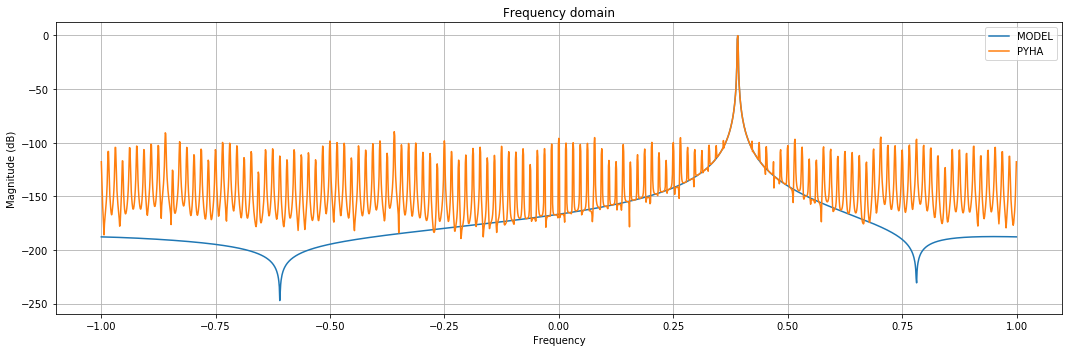

In [7]:
plt.title('Frequency domain')
for key, value in sims.items():
    plt.magnitude_spectrum(value, scale='dB', label=key)
show_plot()

## Other applications
This core can be used to implement phase/amplitude modulators. This will be covered on the documentation of those cores.

# Limitations

## Fixed-point
Expects standard FPGA Fixed point format i.e 18 bits (incl. sign) and scaled to -1...1 range.

In [8]:
print(f'Minimum number representabe: {2**-17}')

Minimum number representabe: 7.62939453125e-06


# Synthesis

In [9]:
# NBVAL_SKIP
output_dir = '/tmp/pyha_output'
dut = NCO()
sims = simulate(dut, input_signal, simulations=['HARDWARE', 'RTL', 'GATE'], conversion_path=output_dir)

assert hardware_sims_equal(sims)

lut, mem, mul = get_resource_usage()
print(f'Logic elements: {lut}')
print(f'Memory: {mem}')
print(f'Multipler (18bit): {mul//2}')

INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 2064/2064 [00:03<00:00, 661.78it/s]

INFO:sim:OK!
INFO:sim:Running "RTL" simulation...
INFO:conversion:Creating top.vhd ...


INFO:conversion:Cordic to VHDL ...
INFO:conversion:NCO to VHDL ...
INFO:sim:Running COCOTB & GHDL simulation....
INFO:sim:OK!
INFO:sim:Running "GATE" simulation...
INFO:conversion:Creating top.vhd ...
INFO:conversion:Cordic to VHDL ...
INFO:conversion:NCO to VHDL ...
INFO:sim:Running quartus map...will take time.
INFO:sim:Analysis & Synthesis Status : Successful - Fri Aug 24 13:31:06 2018
INFO:sim:Quartus Prime Version : 18.0.0 Build 614 04/24/2018 SJ Lite Edition
INFO:sim:Revision Name : quartus_project
INFO:sim:Top-level Entity Name : top
INFO:sim:Family : Cyclone IV E
INFO:sim:Total logic elements : 1,303
INFO:sim:    Total combinational functions : 1,262
INFO:sim:    Dedicated logic registers : 828
INFO:sim:Total registers : 828
INFO:sim:Total pins : 56
INFO:sim:Total virtual pins : 0
INFO:sim:Total memory bits : 0
INFO:sim:Embedded Multiplier 9-bit elements : 0
INFO:sim:Total PLLs : 0
INFO:sim:Running netlist writer.
INFO:sim:Running COCOTB & GHDL simulation....
INFO:sim:OK!
INFO:

Logic elements: 1303
Memory: 0
Multipler (18bit): 0
